이번 스텝에서는 8번 노드에 나왔던 모델과 동일한 모델을 실습합니다.     
하지만 다양한 성능 향상 방법을 사용하여 8번 노드에서의 딥러닝 모델보다 성능을 더 높일 수 있습니다.     
8번 노드에서 사용했던 ReLU와는 다른 활성화함수를 사용해보고, BatchNormalization과 Dropout을 적용해 봅시다.     
ModelCheckpoint와 EarlyStopping 콜백 함수도 적용해 보세요.

### 데이터 로드 및 전처리

* reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
* 데이터셋은 keras.datasets에서 불러올 수 있는 reuters 데이터 셋을 활용하고, 이때 파라메터 조정을 통해 단어의 개수는 10000개로 제한합니다(num_words=10000)
* 데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용합니다.
* 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [15]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# 훈련 데이터에서 25%를 검증 데이터로 분리
x_train, x_val, y_train, y_val = train_test_split(train_data, 
                                                     train_labels,
                                                     test_size=0.25, 
                                                     random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

8982
2246
2246
46


* 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다. 원-핫 인코딩 함수를 직접 만들어보세요.
* 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.

In [16]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, d in enumerate(data):
        results[i, d] = 1.
    return results

x_train = one_hot_encoding(x_train)
x_val = one_hot_encoding(x_val)
x_test = one_hot_encoding(test_data)

# 레이블도 범주형(One-hot) 인코딩
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(test_labels)

## 모델 구성 및 컴파일
BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성합니다.

In [23]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
# 모델 구성
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(46, activation='softmax', name='output'))

# 모델 컴파일
model.compile(optimizer='Adam',
              loss='categorical_crossentropy', # 다중 클래스 분류 (one-hot 인코딩된 레이블)
              metrics=['accuracy'])


In [24]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        25,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 46)             │         9,246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,316,486 (5.02 MB)

 Trainable params: 1,315,830 (5.02 MB)

 Non-trainable params: 656 (2.56 KB)

## 모델 학습
ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.

In [25]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
# 모델 저장 경로 설정
checkpoint_cb = callbacks.ModelCheckpoint('best_model_reuters.h5', save_best_only=True)

# 조기 종료 설정
early_stopping_cb = callbacks.EarlyStopping(patience=5, 
                                            monitor='val_loss',
                                            restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
103/106 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5038 - loss: 2.3897

106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5094 - loss: 2.3637 - val_accuracy: 0.6719 - val_loss: 2.0485
Epoch 2/50
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8667 - loss: 0.6224

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8668 - loss: 0.6222 - val_accuracy: 0.7386 - val_loss: 1.2310
Epoch 3/50
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9395 - loss: 0.3024

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9393 - loss: 0.3032 - val_accuracy: 0.7912 - val_loss: 0.9545
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9541 - loss: 0.2218

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9541 - loss: 0.2221 - val_accuracy: 0.8117 - val_loss: 0.9517
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9590 - loss: 0.1748 - val_accuracy: 0.8157 - val_loss: 1.0393
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9612 - loss: 0.1593 - val_accuracy: 0.8068 - val_loss: 1.0625
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9643 - loss: 0.1277 - val_accuracy: 0.8192 - val_loss: 1.0858
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9665 - loss: 0.1316 - val_accuracy: 0.8183 - val_loss: 1.1244
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9675 - loss: 0.1150 - val_accuracy: 0.8157 - val_loss: 1.1150


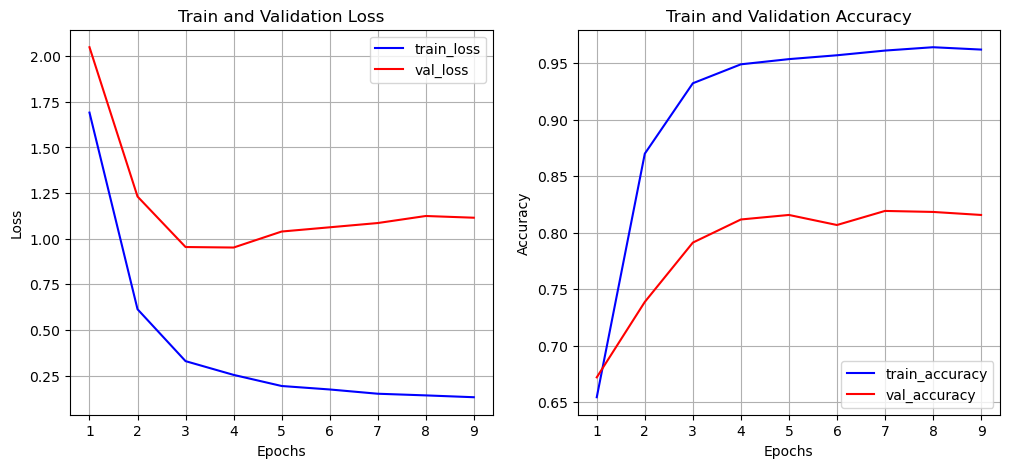

In [26]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
# plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [28]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7896 - loss: 0.9922


[1.0154563188552856, 0.7822796106338501]